In [498]:
import ROOT
import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

ROOT.gROOT.ProcessLine( "gErrorIgnoreLevel = kError;");
ROOT.gStyle.SetCanvasDefW(2400);
ROOT.gStyle.SetCanvasDefH(900);
ROOT.gStyle.SetLegendTextSize(0.05)
ROOT.gStyle.SetLabelSize(0.05)
ROOT.gStyle.SetMarkerSize(1)
ROOT.gStyle.SetMarkerStyle(8)
ROOT.gStyle.SetLineWidth(2)
ROOT.gStyle.SetTextFont(42)
ROOT.gStyle.SetTextSize(0.05)
ROOT.gStyle.SetTickLength(0.02, "y")
ROOT.gStyle.SetHatchesSpacing(1) #to define the spacing between hatches.
ROOT.gStyle.SetHatchesLineWidth(1) #to define the hatches line width.

In [499]:
def human_readable(val):
    if int(val/1e9) > 0:
        return f"{int(val/1e9)}B"
    elif int(val/1e6) > 0:
        return f"{int(val/1e6)}M"
    elif int(val/1e3) > 0:
        return f"{int(val/1e3)}K"
    else:
        return str(int(val))

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e

def add_file(df, file, new_cols):
    new_df = pd.read_csv(file)
    new_df["nvals"] =  new_df["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
    new_df["distribution"] =  new_df["input"].apply(lambda s: s.split("_")[1])
    convert_to_type(new_df, "edges", np.bool_)
    if "ttotal" in new_df:
        convert_to_type(new_df, "ttotal", np.float64)
    for k,v in new_cols.items():
        new_df[k] = v
    df = pd.concat([df, new_df])
    return df

In [500]:
def convert_to_type(df, col, type):
    df[col] =  df[col].apply(lambda s: type(s))

def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])

def filter_name(n):
    # print(n)
    name_map = {
        "Stats" : "Statistics reductions",
        "Sum" : "Statistics reductions",
        "Histo" : "Histogram",
        "ExcludeUOverflowKernel" : "Statistics reductions",
        "InitializeToZeroTask" : "Statistics reductions"
    }
    for w in ["unsigned", "int", "char", "float", "void", "const", "long", "*", "hipsycl_kernel",
              "::operator", "ROOT::", "Experimental::", "_", "::", "]", "[", "  "]:
        n = n.replace(w, "")
    for k,v in name_map.items():
        if k in n:
            n = v

    return n.strip()

def get_cell(df, index_name, col):
    return df.loc[index_name][col]
    
def fill_bar(h, x, w, d, c, s):
    h.Fill(x, w)
    h.SetBinError(h.FindBin(x), d)
    if s:
        h.SetFillStyle(s)
    h.SetLineColor(c)
    h.SetFillColor(c)
    h.SetLineWidth(2)
    h.SetMarkerSize(0)

def get_group(n):
    if n in [
        "cuModuleLoadDataEx",
        "cuModuleUnload",
        "cuModuleGetLoadingMode",
    ]:
        return "Module"
    elif n in [
        "cuEventCreate",
        "cuEventDestroyv2",
        "cuEventQuery",
        "cuEventRecord",
        "cuEventSynchronize",
        "cudaEventCreate",
        "cudaEventDestroy",
        "cudaEventRecord",
        "cudaEventSynchronize",
    ]:
        return "Event"
    elif n in [
        "cuMemAllocv2",
        "cuMemFreev2",
        "cuMemcpyAsync",
        "cuMemsetAsync",
        "cudaMalloc",
        "cudaFree",
        "cudaMemcpyAsync",
        "cudaMemsetAsync",
        "CUDAMalloc",
        "CUDAFree",
        "CUDAMemcpy",
        "CUDAMemset",
    ]:
        return "Memory"
    elif n in [
        "cuStreamWaitEvent",
        "cuStreamCreateWithPriority",
        "cuStreamDestroyv2",
        "cuStreamCreateWithFlags",
        "cudaStreamCreateWithFlags",
        "cudaStreamDestroy",
        "cudaStreamWaitEvent",
    ]:
        return "Stream"
    elif n in [
        "cuLaunchKernel",
        "cudaLaunchKernel",
        "CUDALaunchKernel",
    ]:
        return "Kernel"
    elif n in [
        "cuGetDevicePropertiesv2v12000",
        "cudaGetDevicePropertiesv2v12000",
    ]:
        return "Properties"

def get_group_color(name):
    g_dict = {
        "Event" : ROOT.kGreen,
        "Kernel" : ROOT.kOrange,
        "Module" : ROOT.kBlue,
        "Memory" : ROOT.kRed,
        "Stream" : ROOT.kMagenta,
        "Properties" : ROOT.kBlack,
    }

    if name in g_dict:
        return g_dict[name]

def get_color(name, lbls):
    c_dict = {
        "cuModuleLoadDataEx" : ROOT.kBlue,
        "cuModuleUnload" : ROOT.kBlue+1,
        "cuModuleGetLoadingMode": ROOT.kBlue+2,
        "cuEventCreate": ROOT.kGreen,
        "cuEventDestroyv2": ROOT.kGreen+1,
        "cuEventQuery": ROOT.kGreen+2,
        "cuEventRecord": ROOT.kGreen+3,
        "cuEventSynchronize": ROOT.kGreen+4,
        "cuGetDevicePropertiesv2v12000": ROOT.kBlack,
        "cuLaunchKernel": ROOT.kOrange,
        "cuMemAllocv2": ROOT.kRed,
        "cuMemFreev2": ROOT.kRed+1,
        "cuMemcpyAsync": ROOT.kRed+2,
        "cuMemsetAsync": ROOT.kRed+3,
        "cuStreamWaitEvent": ROOT.kMagenta,
        "cuStreamCreateWithPriority": ROOT.kMagenta+1,
        "cuStreamDestroyv2": ROOT.kMagenta+2,
        "cuStreamCreateWithFlags": ROOT.kMagenta+3,
        
        "cudaEventCreate": ROOT.kGreen,
        "cudaEventDestroy": ROOT.kGreen+1,
        "cudaEventRecord": ROOT.kGreen+3,
        "cudaEventSynchronize": ROOT.kGreen+4,
        "cudaGetDevicePropertiesv2v12000": ROOT.kBlack,
        "cudaLaunchKernel": ROOT.kOrange,
        "cudaMalloc": ROOT.kRed,
        "cudaFree": ROOT.kRed+1,
        "cudaMemcpyAsync": ROOT.kRed+2,
        "cudaMemsetAsync": ROOT.kRed+3,
        "cudaStreamCreateWithFlags": ROOT.kMagenta,
        "cudaStreamDestroy": ROOT.kMagenta+2,
        "cudaStreamWaitEvent": ROOT.kMagenta+3,
        
        "CUDALaunchKernel": ROOT.kOrange,
        "CUDAMalloc": ROOT.kRed,
        "CUDAFree": ROOT.kRed+1,
        "CUDAMemcpy": ROOT.kRed+2,
        "CUDAMemset": ROOT.kRed+3,

    }

    if name in c_dict:
        return c_dict[name]

In [501]:
groupby_list = ["env", "gpu", "cc", "type", "distribution", "nvals", "nbins", "bulksize", "edges", "reduction"]

In [502]:
df = pd.read_csv("das6-gpu/20231206-174647")
df["nvals"] =  df["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
df["distribution"] =  df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df, "edges", np.bool_)
convert_to_type(df, "ttotal", np.float64)
df["type"] = "Buffers"
df["cc"] = 86
df["reduction"] = 8

df = add_file(df, "das6-gpu/20231211-155923", 
              { 
                  "type" : "USM", 
                  "cc" : 86,
                  "reduction" : 8
              })

df = add_file(df, "das6-gpu/20231127-085724", 
              { 
                  "type" : "USM", 
                  "cc" : 75,
                  "reduction" : 8
              })

df = add_file(df, "das6-gpu/reduction_range", 
              { 
                  "type" : "USM", 
                  "cc" : 86
              })
df = add_file(df, "das6-gpu/usm_sm75", 
              { 
                  "type" : "USM", 
              })

del df["input"]
df

,iter,env,gpu,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution,type,cc,reduction
0,0,DPC++,A4000,1,32768,False,0.0,0.0,0.0,3.158348,5.000000e+07,uniform,Buffers,86,8
1,0,DPC++,A4000,1,32768,True,0.0,0.0,0.0,3.143772,5.000000e+07,uniform,Buffers,86,8
2,0,DPC++,A4000,1,32768,False,0.0,0.0,0.0,3.593378,1.000000e+08,uniform,Buffers,86,8
3,0,DPC++,A4000,1,32768,True,0.0,0.0,0.0,4.094069,1.000000e+08,uniform,Buffers,86,8
4,0,DPC++,A4000,1,32768,False,0.0,0.0,0.0,9.966019,5.000000e+08,uniform,Buffers,86,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,3,AdaptiveCpp,A4000,1000,32768,True,0.0,0.0,0.0,31.383447,1.000000e+09,uniform,USM,75,2
16,4,AdaptiveCpp,A4000,1000,32768,True,0.0,0.0,0.0,6.770405,5.000000e+07,uniform,USM,75,2
17,4,AdaptiveCpp,A4000,1000,32768,True,0.0,0.0,0.0,8.107657,1.000000e+08,uniform,USM,75,2
18,4,AdaptiveCpp,A4000,1000,32768,True,0.0,0.0,0.0,17.971192,5.000000e+08,uniform,USM,75,2


In [503]:
gp = df.groupby(groupby_list)
gp.mean()

iter  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction         
AdaptiveCpp A2    75 USM  uniform      5.000000e+07 1     32768    False 8           2.0   
                                                                   True  8           2.0   
                                                    10    32768    False 8           2.0   
                                                                   True  8           2.0   
                                                    100   32768    False 8           2.0   
...                                                                                  ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 10    32768    True  8           2.0   
                                                    100   32768    False 8           2.0   
                                                                   True  8           2.0   
                                                    1000  32768    False 8           2.0   
                                                                   True  8           2.0   

                                                                                    tfindbin  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction             
AdaptiveCpp A2    75 USM  uniform      5.000000e+07 1     32768    False 8               0.0   
                                                                   True  8               0.0   
                                                    10    32768    False 8               0.0   
                                                                   True  8               0.0   
                                                    100   32768    False 8               0.0   
...                                                                                      ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 10    32768    True  8               0.0   
                                                    100   32768    False 8               0.0   
                                                                   True  8               0.0   
                                                    1000  32768    False 8               0.0   
                                                                   True  8               0.0   

                                                                                    tfill  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction          
AdaptiveCpp A2    75 USM  uniform      5.000000e+07 1     32768    False 8            0.0   
                                                                   True  8            0.0   
                                                    10    32768    False 8            0.0   
                                                                   True  8            0.0   
                                                    100   32768    False 8            0.0   
...                                                                                   ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 10    32768    True  8            0.0   
                                                    100   32768    False 8            0.0   
                                                                   True  8            0.0   
                                                    1000  32768    False 8            0.0   
                                                                   True  8            0.0   

                                                                                    tstats  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction           
AdaptiveCpp A2    75 USM  uniform      5.000000e+07 1     32768    False 8             0.0   
                                                                   True  8             0.0   
                                                    

In [504]:
unique_env = df["env"].unique()
unique_bulksize = np.sort(df["bulksize"].unique())
unique_nbins = np.sort(df["nbins"].unique())
unique_nvals = np.sort(df["nvals"].unique().astype(np.float64))
unique_gpus = df["gpu"].unique()
unique_distributions = df["distribution"].unique()
unique_edges = [True, False]
unique_type = ["Buffers", "USM"]
unique_cc = [75,86]
unique_reduction = np.sort(df["reduction"].unique())
unique_env, unique_gpus, unique_type, unique_nbins, unique_bulksize, unique_edges, unique_nvals, unique_distributions, unique_cc, unique_reduction

(array(['DPC++', 'AdaptiveCpp', 'CUDA'], dtype=object),
 array(['A4000', 'A2', 'A6000'], dtype=object),
 ['Buffers', 'USM'],
 array([   1,   10,  100, 1000]),
 array([32768]),
 [True, False],
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array(['uniform'], dtype=object),
 [75, 86],
 array([-2,  1,  2,  4,  8, 16]))

In [505]:
api_buf = pd.read_csv("das6-gpu/nsys-20231211-155923/api")
api_buf["nvals"] =  api_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
api_buf["distribution"] =  api_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(api_buf, "edges", np.bool_)
api_buf["type"] = "Buffers"
api_buf["cc"] = 86
api_buf["reduction"] = 8

api = add_file(api_buf, "das6-gpu/nsys-20231206-174647/api", 
              { 
                  "type" : "USM", 
                  "cc" : 86,
                  "reduction" : 8
              })

api = add_file(api, "das6-gpu/nsys-20231127-085724//api", 
              { 
                  "type" : "USM", 
                  "cc" : 75,
                  "reduction" : 8
              })

api = add_file(api, "das6-gpu/nsys-reduction_range/api", 
              { 
                  "type" : "USM", 
                  "cc" : 86
              })
api = add_file(api, "das6-gpu/nsys-usm_sm75/api", 
              { 
                  "type" : "USM", 
                  "cc" : 75,
              })

api["Name"] = api["Name"].apply(filter_name)
api["Time"] = api["Total Time (ns)"].div(1e9)
del api["input"]
api = api.copy()
api

,iter,env,gpu,nbins,bulksize,edges,Time (%),Total Time (ns),Num Calls,Avg (ns),...,Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution,type,cc,reduction,Time
0,0,AdaptiveCpp,A4000,1,32768,False,31.1,226624986,10690,21199.7,...,6753,132465001,1281105.6,cudaLaunchKernel,5.000000e+07,uniform,Buffers,86,8,0.226625
1,0,AdaptiveCpp,A4000,1,32768,False,23.2,168862502,4,42215625.5,...,2985,168851322,84423797.7,cudaStreamCreateWithFlags,5.000000e+07,uniform,Buffers,86,8,0.168863
2,0,AdaptiveCpp,A4000,1,32768,False,22.6,164683254,3064,53747.8,...,5851,119444,5370.4,cudaMemcpyAsync,5.000000e+07,uniform,Buffers,86,8,0.164683
3,0,AdaptiveCpp,A4000,1,32768,False,6.6,47877497,6118,7825.7,...,4238,332824,7542.2,cudaFree,5.000000e+07,uniform,Buffers,86,8,0.047877
4,0,AdaptiveCpp,A4000,1,32768,False,6.6,47789458,6118,7811.3,...,4638,537979,8192.6,cudaMalloc,5.000000e+07,uniform,Buffers,86,8,0.047789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,4,AdaptiveCpp,A4000,1000,32768,True,0.0,136506,1,136506.0,...,136506,136506,0.0,cudaGetDevicePropertiesv2v12000,1.000000e+09,uniform,USM,75,2,0.000137
276,4,AdaptiveCpp,A4000,1000,32768,True,0.0,94756,3,31585.3,...,5390,81452,43204.2,cudaMemsetAsync,1.000000e+09,uniform,USM,75,2,0.000095
277,4,AdaptiveCpp,A4000,1000,32768,True,0.0,32442,4,8110.5,...,4870,17242,6089.7,cudaStreamDestroy,1.000000e+09,uniform,USM,75,2,0.000032
278,4,AdaptiveCpp,A4000,1000,32768,True,0.0,21267,13,1635.9,...,1302,2525,328.0,cudaEventDestroy,1.000000e+09,uniform,USM,75,2,0.000021


In [506]:
gp_api = api.groupby([*groupby_list, "Name"])
gp_api.mean()

iter  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Name                               
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode       2.0   
                                                                                   cudaEventCreate              2.0   
                                                                                   cudaEventDestroy             2.0   
                                                                                   cudaEventRecord              2.0   
                                                                                   cudaEventSynchronize         2.0   
...                                                                                                             ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 1000  32768    True  8         cuModuleUnload               2.0   
                                                                                   cuStreamCreateWithPriority   2.0   
                                                                                   cuStreamDestroyv2            2.0   
                                                                                   cuStreamSynchronize          2.0   
                                                                                   cuStreamWaitEvent            2.0   

                                                                                                               Time (%)  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Name                                   
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode          0.00   
                                                                                   cudaEventCreate                 0.00   
                                                                                   cudaEventDestroy                0.00   
                                                                                   cudaEventRecord                 2.00   
                                                                                   cudaEventSynchronize            0.16   
...                                                                                                                 ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 1000  32768    True  8         cuModuleUnload                  0.10   
                                                                                   cuStreamCreateWithPriority      0.00   
                                                                                   cuStreamDestroyv2               0.00   
                                                                                   cuStreamSynchronize             0.00   
                                                                                   cuStreamWaitEvent               0.10   

                                                                                                               Total Time (ns)  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Name                                          
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         cuModuleGetLoadingMode               3424.2   
                                                                                   cudaEventCreate                    242167.8   
                                                                                   cudaEventDestroy                    24505.8   
                                                                                   cudaEventRecord                 100902600.8   
                                                                                   cudaEventSynchronize              7428639.0   
...                                                  

In [507]:
api_names = api["Name"].unique()
api_names

array(['cudaLaunchKernel', 'cudaStreamCreateWithFlags', 'cudaMemcpyAsync',
       'cudaFree', 'cudaMalloc', 'cudaEventRecord', 'cudaStreamWaitEvent',
       'cudaEventSynchronize', 'cudaEventCreate',
       'cudaGetDevicePropertiesv2v12000', 'cudaStreamDestroy',
       'cudaMemsetAsync', 'cudaEventDestroy', 'cuModuleGetLoadingMode',
       'cuModuleLoadDataEx', 'cuModuleUnload', 'cuMemcpyHtoDAsyncv2',
       'cuLaunchKernel', 'cuMemAllocv2', 'cuMemFreev2',
       'cuEventSynchronize', 'cuStreamWaitEvent', 'cuEventQuery',
       'cuEventRecord', 'cuEventCreate', 'cuEventDestroyv2',
       'cuStreamCreateWithPriority', 'cuStreamDestroyv2',
       'cuStreamSynchronize', 'cuMemcpyDtoHAsyncv2', 'cuMemcpyAsync',
       'cuMemsetD8Async', 'cuCtxSetCurrent', 'CUDALaunchKernel',
       'CUDAFree', 'CUDAStreamCreateWithFlags', 'CUDAEventRecord',
       'CUDAMemcpyAsync', 'CUDAMalloc', 'CUDAStreamWaitEvent',
       'CUDAEventSynchronize', 'CUDAEventCreate',
       'CUDAGetDevicePropertiesv2v12000

In [508]:
kernels_buf = pd.read_csv("das6-gpu/nsys-20231211-155923/kernel")
kernels_buf["nvals"] =  kernels_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
kernels_buf["distribution"] =  kernels_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(kernels_buf, "edges", np.bool_)
kernels_buf["type"] = "Buffers"
kernels_buf["cc"] = 86
kernels_buf["reduction"] = 8


kernels = add_file(kernels_buf, "das6-gpu/nsys-20231206-174647/kernel", 
              { 
                  "type" : "USM", 
                  "cc" : 86,
                  "reduction" : 8
              })
kernels = add_file(kernels, "das6-gpu/nsys-20231127-085724/kernel", 
              { 
                  "type" : "USM", 
                  "cc" : 75,
                  "reduction" : 8
              })
kernels = add_file(kernels, "das6-gpu/nsys-reduction_range/kernel", 
              { 
                  "type" : "USM", 
                  "cc" : 86
              })
kernels = add_file(kernels, "das6-gpu/nsys-usm_sm75/kernel", 
              { 
                  "type" : "USM", 
                  "cc" : 75,
              })

kernels["Name"] = kernels["Name"].apply(filter_name)
kernels["Time"] = kernels["Total Time (ns)"].div(1e9)
del kernels["input"]
kernels_unfiltered = kernels.copy()
kernels

,iter,env,gpu,nbins,bulksize,edges,Time (%),Total Time (ns),Instances,Avg (ns),...,Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution,type,cc,reduction,Time
0,0,AdaptiveCpp,A4000,1,32768,False,72.6,81750572,1527.0,53536.7,...,39136,55777.0,738.1,Histogram,5.000000e+07,uniform,Buffers,86,8,0.081751
1,0,AdaptiveCpp,A4000,1,32768,False,7.1,8036343,1527.0,5262.8,...,5215,5472.0,24.7,Statistics reductions,5.000000e+07,uniform,Buffers,86,8,0.008036
2,0,AdaptiveCpp,A4000,1,32768,False,6.8,7645544,1527.0,5006.9,...,4960,5344.0,21.0,Statistics reductions,5.000000e+07,uniform,Buffers,86,8,0.007646
3,0,AdaptiveCpp,A4000,1,32768,False,4.6,5125609,1527.0,3356.7,...,3327,3393.0,11.8,Statistics reductions,5.000000e+07,uniform,Buffers,86,8,0.005126
4,0,AdaptiveCpp,A4000,1,32768,False,4.5,5121366,1527.0,3353.9,...,3327,3392.0,13.3,Statistics reductions,5.000000e+07,uniform,Buffers,86,8,0.005121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,4,AdaptiveCpp,A4000,1000,32768,True,15.5,140964907,30534.0,4616.7,...,3616,4832.0,21.7,Statistics reductions,1.000000e+09,uniform,USM,75,2,0.140965
136,4,AdaptiveCpp,A4000,1000,32768,True,11.3,103350416,30534.0,3384.8,...,3328,3425.0,14.2,Statistics reductions,1.000000e+09,uniform,USM,75,2,0.103350
137,4,AdaptiveCpp,A4000,1000,32768,True,11.3,103135338,30534.0,3377.7,...,3359,3425.0,15.9,Statistics reductions,1.000000e+09,uniform,USM,75,2,0.103135
138,4,AdaptiveCpp,A4000,1000,32768,True,6.0,55080632,30534.0,1803.9,...,1600,2208.0,16.1,Statistics reductions,1.000000e+09,uniform,USM,75,2,0.055081


In [509]:
gp_kernels = kernels.groupby([*groupby_list, "Name"])
gp_kernels.mean()

iter  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Name                          
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         Histogram               2.0   
                                                                                   Statistics reductions   2.0   
                                       1.000000e+08 1000  32768    True  2         Histogram               2.0   
                                                                                   Statistics reductions   2.0   
                                       5.000000e+08 1000  32768    True  2         Histogram               2.0   
...                                                                                                        ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 100   32768    True  8         Statistics reductions   2.0   
                                                    1000  32768    False 8         Histogram               2.0   
                                                                                   Statistics reductions   2.0   
                                                                   True  8         Histogram               2.0   
                                                                                   Statistics reductions   2.0   

                                                                                                           Time (%)  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Name                               
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         Histogram              34.120000   
                                                                                   Statistics reductions  10.976667   
                                       1.000000e+08 1000  32768    True  2         Histogram              34.100000   
                                                                                   Statistics reductions  10.970000   
                                       5.000000e+08 1000  32768    True  2         Histogram              34.100000   
...                                                                                                             ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 100   32768    True  8         Statistics reductions  10.200000   
                                                    1000  32768    False 8         Histogram              17.900000   
                                                                                   Statistics reductions  10.262500   
                                                                   True  8         Histogram              19.600000   
                                                                                   Statistics reductions  10.060000   

                                                                                                          Total Time (ns)  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Name                                     
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         Histogram                 1.555433e+07   
                                                                                   Statistics reductions     4.999953e+06   
                                       1.000000e+08 1000  32768    True  2         Histogram                 3.109849e+07   
                                                                                   Statistics reductions     1.000321e+07   
                                       5.000000e+08 1000  32768    True  2         Histogram                 1.554311e+08   
...                                                                                                                   ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 100   32768    True  8 

In [510]:
kernel_names = kernels["Name"].unique()
kernel_names

array(['Histogram', 'Statistics reductions'], dtype=object)

In [511]:
memops_buf = pd.read_csv("das6-gpu/nsys-20231211-155923/memop")
memops_buf["nvals"] =  memops_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
memops_buf["distribution"] =  memops_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(kernels_buf, "edges", np.bool_)
memops_buf["type"] = "Buffers"
memops_buf["cc"] = 86
memops_buf["reduction"] = 8

df_memops = add_file(memops_buf, "das6-gpu/nsys-20231206-174647/memop", 
              { 
                  "type" : "USM", 
                  "cc" : 86,
                  "reduction" : 8
              })

df_memops = add_file(df_memops, "das6-gpu/nsys-20231127-085724/memop", 
              { 
                  "type" : "USM", 
                  "cc" : 75,
                  "reduction" : 8
              })

df_memops = add_file(df_memops, "das6-gpu/nsys-reduction_range/memop", 
              { 
                  "type" : "USM", 
                  "cc" : 86
              })
df_memops = add_file(df_memops, "das6-gpu/nsys-usm_sm75/memop", 
              { 
                  "type" : "USM", 
                  "cc" : 75,
              })

del df_memops["input"]
df_memops["Time"] = df_memops["Total Time (ns)"].div(1e9)
df_memops_unfiltered = df_memops.copy()
df_memops["Operation"] = df_memops["Operation"].apply(filter_name)
df_memops

,iter,env,gpu,nbins,bulksize,edges,Time (%),Total Time (ns),Count,Avg (ns),...,Min (ns),Max (ns),StdDev (ns),Operation,nvals,distribution,type,cc,reduction,Time
0,0,AdaptiveCpp,A4000,1,32768,False,100.0,47118513,3062,15388.1,...,415,16321,776.4,CUDA memcpy Host-to-Device,5.000000e+07,uniform,Buffers,86,8,4.711851e-02
1,0,AdaptiveCpp,A4000,1,32768,False,0.0,3104,2,1552.0,...,1536,1568,22.6,CUDA memcpy Device-to-Host,5.000000e+07,uniform,Buffers,86,8,3.104000e-06
2,0,AdaptiveCpp,A4000,1,32768,False,0.0,864,2,432.0,...,416,448,22.6,CUDA memset,5.000000e+07,uniform,Buffers,86,8,8.640000e-07
3,0,AdaptiveCpp,A4000,1,32768,True,100.0,46987364,3063,15340.3,...,415,16033,814.6,CUDA memcpy Host-to-Device,5.000000e+07,uniform,Buffers,86,8,4.698736e-02
4,0,AdaptiveCpp,A4000,1,32768,True,0.0,2848,2,1424.0,...,1344,1504,113.1,CUDA memcpy Device-to-Host,5.000000e+07,uniform,Buffers,86,8,2.848000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,4,AdaptiveCpp,A4000,1000,32768,True,0.0,2625,2,1312.5,...,1184,1441,181.7,CUDA memcpy Device-to-Host,5.000000e+08,uniform,USM,75,2,2.625000e-06
56,4,AdaptiveCpp,A4000,1000,32768,True,0.0,2528,3,842.7,...,416,1696,739.0,CUDA memset,5.000000e+08,uniform,USM,75,2,2.528000e-06
57,4,AdaptiveCpp,A4000,1000,32768,True,100.0,943687037,61073,15451.8,...,416,16608,235.9,CUDA memcpy Host-to-Device,1.000000e+09,uniform,USM,75,2,9.436870e-01
58,4,AdaptiveCpp,A4000,1000,32768,True,0.0,2688,2,1344.0,...,1184,1504,226.3,CUDA memcpy Device-to-Host,1.000000e+09,uniform,USM,75,2,2.688000e-06


In [512]:
gp_memops = df_memops.groupby([*groupby_list, "Operation"])
gp_memops.mean()

iter  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Operation                          
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                   CUDA memcpy Host-to-Device   2.0   
                                                                                   CUDA memset                  2.0   
                                       1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                   CUDA memcpy Host-to-Device   2.0   
...                                                                                                             ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 1000  32768    False 8         CUDA memcpy Host-to-Device   2.0   
                                                                                   CUDA memset                  2.0   
                                                                   True  8         CUDA memcpy Device-to-Host   2.0   
                                                                                   CUDA memcpy Host-to-Device   2.0   
                                                                                   CUDA memset                  2.0   

                                                                                                               Time (%)  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Operation                              
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host       0.0   
                                                                                   CUDA memcpy Host-to-Device     100.0   
                                                                                   CUDA memset                      0.0   
                                       1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host       0.0   
                                                                                   CUDA memcpy Host-to-Device     100.0   
...                                                                                                                 ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 1000  32768    False 8         CUDA memcpy Host-to-Device     100.0   
                                                                                   CUDA memset                      0.0   
                                                                   True  8         CUDA memcpy Device-to-Host       0.0   
                                                                                   CUDA memcpy Host-to-Device     100.0   
                                                                                   CUDA memset                      0.0   

                                                                                                               Total Time (ns)  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Operation                                     
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host           3123.0   
                                                                                   CUDA memcpy Host-to-Device       47175291.2   
                                                                                   CUDA memset                          2592.2   
                                       1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host           2867.2   
                                                                                   CUDA memcpy Host-to-Device       94210195.2   
...                                                  

In [513]:
memops_names = df_memops["Operation"].unique()
memops_names

array(['CUDA memcpy Host-to-Device', 'CUDA memcpy Device-to-Host',
       'CUDA memset'], dtype=object)

## A4000

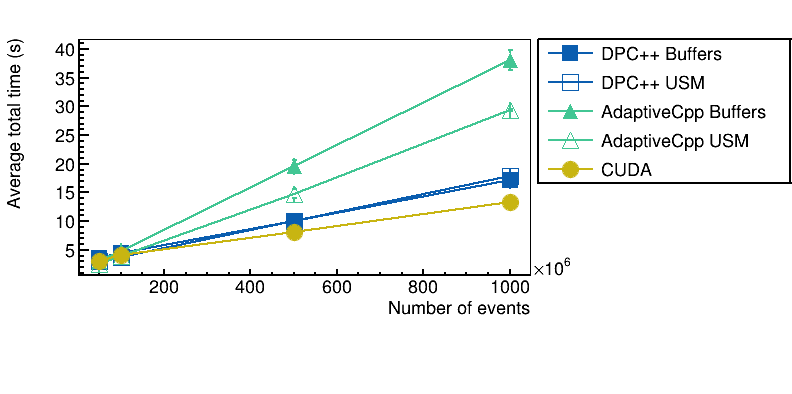

In [514]:
%jsroot off
title = f"Total Runtime of Histo1D with Different Input Sizes on NVIDIA A4000"

selected_env = unique_env
selected_bulksize = 32768
selected_type = unique_type
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 8

w = 800
h = 450
c = ROOT.TCanvas("c1", "", w, h)
c.SetRightMargin(0.33)
c.SetBottomMargin(0.3)

mg = ROOT.TMultiGraph()

l = ROOT.TLegend(0.68, 0.533, 1, 0.9)
l.SetTextSize(0.05)
markerstyles = [21, 25, 22, 26, 20, 20]

ROOT.gStyle.SetPalette(ROOT.kRainbow)  
for ei, env in enumerate(selected_env):
    for ti, type in enumerate(selected_type):
        if type == "USM" and "CUDA" in env:
            continue 
        avg = np.array(gp.mean().loc[env, selected_gpu, selected_cc, type, selected_distr, :, 
               selected_bins, selected_bulksize, selected_edges, selected_red]["ttotal"], dtype=np.float64)
        std = np.array(gp.std().loc[env, selected_gpu, selected_cc, type, selected_distr, :, 
               selected_bins, selected_bulksize, selected_edges, selected_red]["ttotal"], dtype=np.float64)
        gr = ROOT.TGraphErrors(len(selected_nvals), selected_nvals.astype(np.float64), avg, 
                               np.repeat(0., len(selected_nvals)), std)
    
        color = ROOT.TColor.GetPalette()[50+ 60 * ei]
        gr.SetMarkerColor(color)
        gr.SetLineColor(color)
        gr.SetLineWidth(2)
        gr.SetMarkerSize(2)
        gr.SetMarkerStyle(markerstyles[2*ei + ti])
        
        gr.GetHistogram().SetMinimum(0)
        gr.GetHistogram().SetLineWidth(10)
    
        mg.Add(gr, "ALP ")
        l.AddEntry(gr, env.split("_")[0] + " " + (type if "CUDA" not in env else ""))

# mg.SetTitle(title)

xaxis = mg.GetXaxis()
# xaxis.SetTitle("#splitline{Bulk Size}")
xaxis.SetTitle("Number of events")
# xaxis.SetRangeUser(0, 10000000)
# xaxis.SetTitleOffset(1.5)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("hM")
# xaxis.SetTickSize(0)

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average total time (s)")
yaxis.SetTitleOffset(1)
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)

ROOT.gStyle.SetTitleFontSize(0.1)

mg.Draw("a")
l.Draw()
c.SaveAs(f"sycl_totalruntime.pdf")
c.DrawClone()

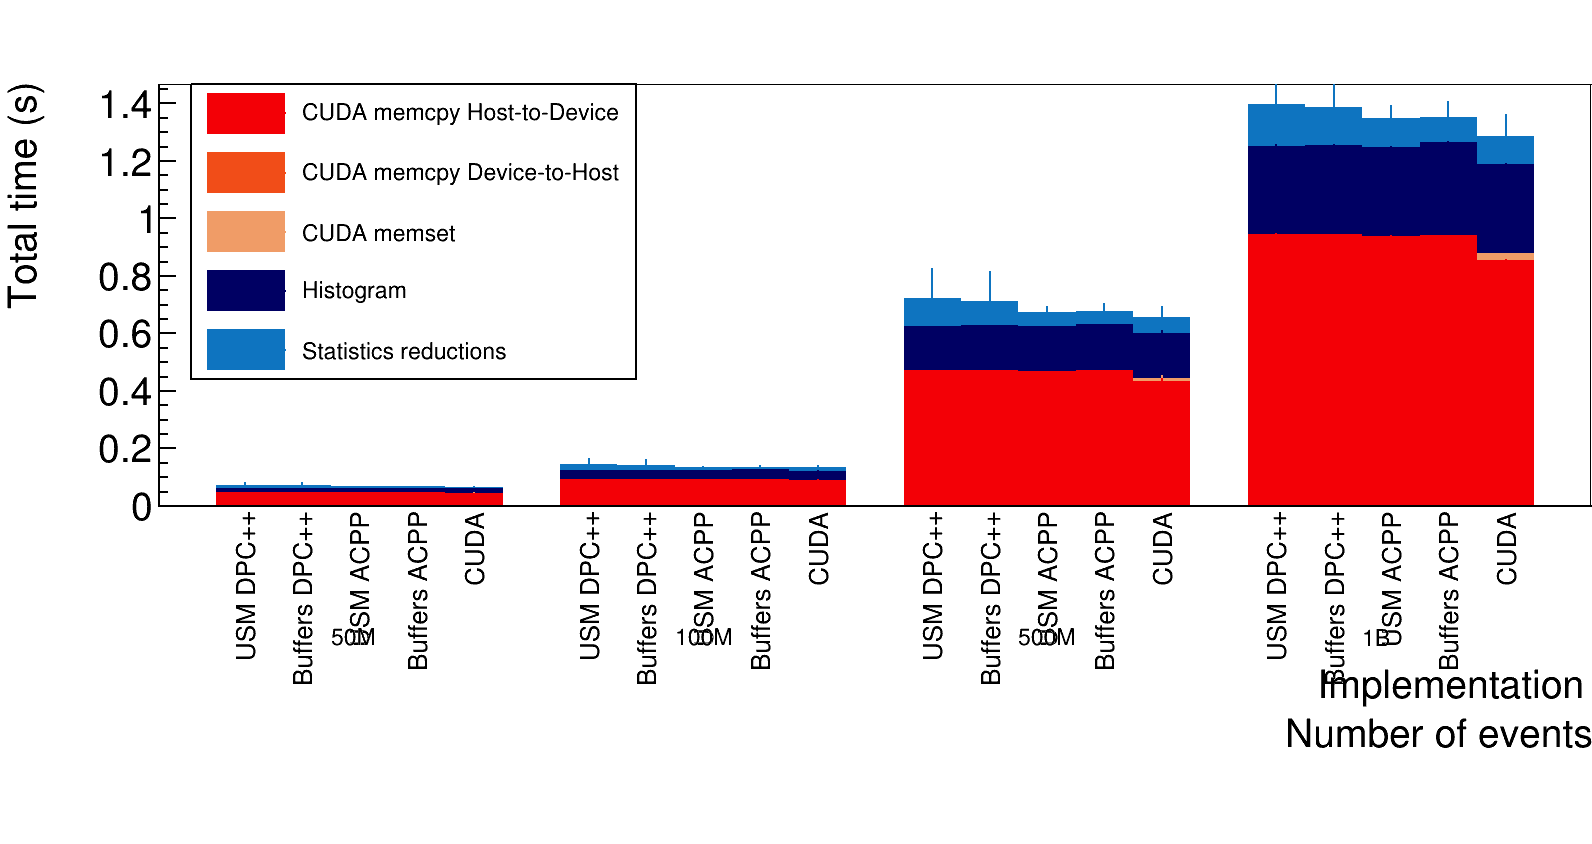

In [515]:
%jsroot off

selected_env = unique_env
selected_bulksize = 32768
selected_type = unique_type
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 8

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 25
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [None, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)
c.SetBottomMargin(0.4)

hs = ROOT.THStack("hs212", "")

rmargin = 0
c.SetRightMargin(rmargin)
l = ROOT.TLegend(0.12, 0.55, 0.4, 0.9)
l.SetTextSize(0.03)

unique_kernels = []

for ei, (env, typ) in enumerate([["DPC++", "USM"], ["DPC++", "Buffers"], ["AdaptiveCpp", "USM"], ["AdaptiveCpp", "Buffers"], ["CUDA", "USM"]]):
    ROOT.gStyle.SetPalette(ROOT.kBlackBody)
    for mi, memop in enumerate(memops_names):
        bin = 1 + ei
        for nvi, nv in enumerate(selected_nvals):
            arg = (env, selected_gpu, selected_cc, 
                 typ, selected_distr, nv, selected_bins, 
                 selected_bulksize, selected_edges, selected_red)
            memop_avg = gp_memops.mean().loc[arg]
            memop_std = gp_memops.std().loc[arg]
    
            if len(memop_avg) == 0 or memop not in memop_avg.index:
                continue
            # print(env, typ, bin, get_cell(memop_avg, memop, "Time"))
    
            h3 = ROOT.TH1F(f"{env}_{typ}_{memop}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                get_cell(memop_avg, memop, "Time"),
                get_cell(memop_std, memop, "Time"),
                ROOT.TColor.GetPalette()[50 * mi],
                gpuFillStyle[ei],
            )
            hs.Add(h3)
            bin += 6
        if ei == 0:
            l.AddEntry(h3, memop)

    ROOT.gStyle.SetPalette(ROOT.kRainbow)
    for ni, name in enumerate(kernel_names):
        bin = 1 + ei
        for nvi, nv in enumerate(selected_nvals):
            arg = (env, selected_gpu, selected_cc, 
                 typ, selected_distr, nv, selected_bins, 
                 selected_bulksize, selected_edges, selected_red)
            kernel_avg = gp_kernels.mean().loc[arg]
            kernel_std = gp_kernels.std().loc[arg]

            if len(kernel_avg) == 0 or name not in kernel_avg.index:
                continue
                
            h1 = ROOT.TH1F(f"{env}_{type}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h1,
                bin,
                get_cell(kernel_avg, name, "Time"),
                get_cell(kernel_std, name, "Time"),
                ROOT.TColor.GetPalette()[60 * ni],
                gpuFillStyle[ei],
            )
            hs.Add(h1)
            bin += 6
        if name not in unique_kernels:
            l.AddEntry(h1, name)
            unique_kernels.append(name)

hs.SetTitle(title)
hs.Draw("bar")

xaxis = hs.GetXaxis()
xaxis.SetTitle("#splitline{   Implementation}{Number of events}")
# xaxis.SetTitle("Bulk size")
def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 6)):
    for ei, (env, typ) in enumerate([["DPC++", "USM"], ["DPC++", "Buffers"], ["AdaptiveCpp", "USM"], ["AdaptiveCpp", "Buffers"], ["CUDA_HIST", ""]]):
        xaxis.SetBinLabel(e + ei, f"{typ} {map_env(env)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.SetTitleOffset(3)
xaxis.SetTitleSize(0.05)
xaxis.LabelsOption("vM")
xaxis.SetLabelSize(0.05)
xaxis.SetTickSize(0)


ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
        "S",  # ndiv, chopts
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.13)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(4, nbins + 1, 6)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total time (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/nsys_histogram_buf_vs_usm.pdf")
c.DrawClone()

In [516]:
gp_memops.mean()

iter  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Operation                          
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                   CUDA memcpy Host-to-Device   2.0   
                                                                                   CUDA memset                  2.0   
                                       1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host   2.0   
                                                                                   CUDA memcpy Host-to-Device   2.0   
...                                                                                                             ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 1000  32768    False 8         CUDA memcpy Host-to-Device   2.0   
                                                                                   CUDA memset                  2.0   
                                                                   True  8         CUDA memcpy Device-to-Host   2.0   
                                                                                   CUDA memcpy Host-to-Device   2.0   
                                                                                   CUDA memset                  2.0   

                                                                                                               Time (%)  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Operation                              
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host       0.0   
                                                                                   CUDA memcpy Host-to-Device     100.0   
                                                                                   CUDA memset                      0.0   
                                       1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host       0.0   
                                                                                   CUDA memcpy Host-to-Device     100.0   
...                                                                                                                 ...   
DPC++       A6000 75 USM  uniform      1.000000e+09 1000  32768    False 8         CUDA memcpy Host-to-Device     100.0   
                                                                                   CUDA memset                      0.0   
                                                                   True  8         CUDA memcpy Device-to-Host       0.0   
                                                                                   CUDA memcpy Host-to-Device     100.0   
                                                                                   CUDA memset                      0.0   

                                                                                                               Total Time (ns)  \
env         gpu   cc type distribution nvals        nbins bulksize edges reduction Operation                                     
AdaptiveCpp A4000 75 USM  uniform      5.000000e+07 1000  32768    True  2         CUDA memcpy Device-to-Host           3123.0   
                                                                                   CUDA memcpy Host-to-Device       47175291.2   
                                                                                   CUDA memset                          2592.2   
                                       1.000000e+08 1000  32768    True  2         CUDA memcpy Device-to-Host           2867.2   
                                                                                   CUDA memcpy Host-to-Device       94210195.2   
...                                                  

In [517]:
np.sort(api_names)[:3]

array(['CUDAEventCreate', 'CUDAEventDestroy', 'CUDAEventRecord'],
      dtype=object)

# AOT

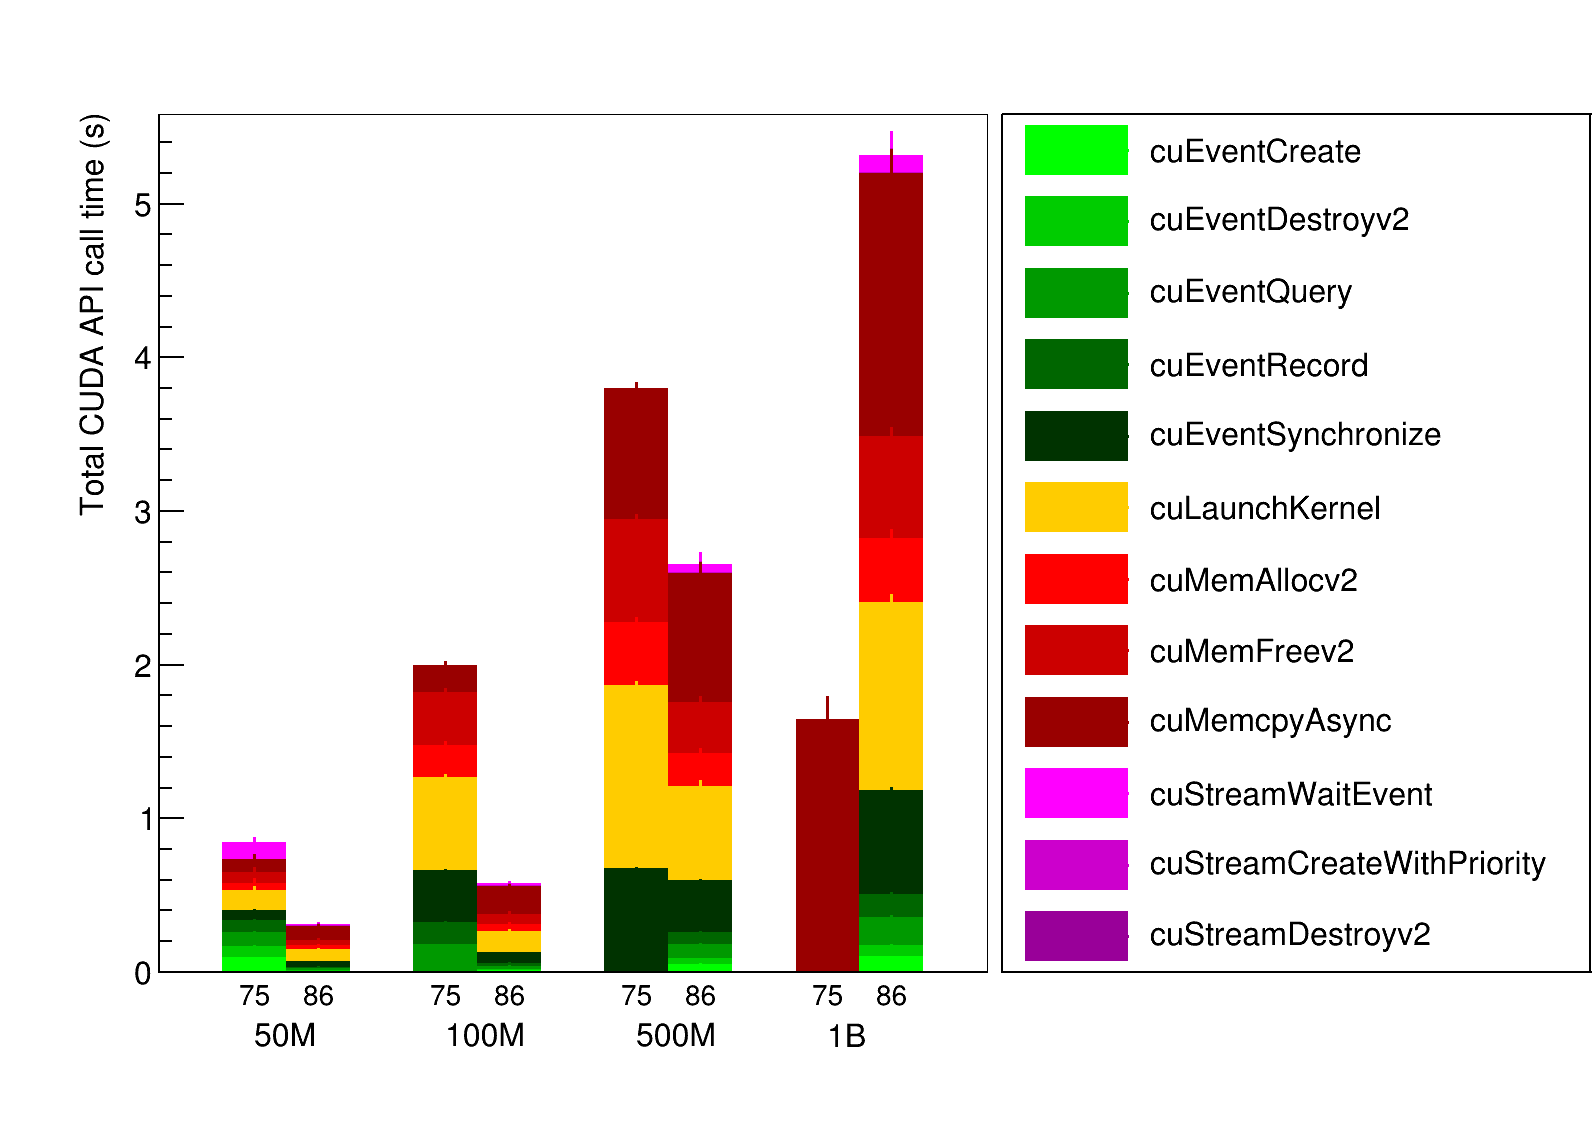

In [572]:
%jsroot off
selected_env = "DPC++"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [75,86]
selected_red = 8

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 2 * len(selected_nvals) + 5
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [40, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1200
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.15
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)

# l = ROOT.TLegend()
l.SetTextSize(0.03)

unique_labels = []
for ci, cc in enumerate(selected_cc):    
    other = 0
    for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals): 
            if len(unique_labels) >-1:
                arg = (selected_env, selected_gpu, cc,
                       selected_type, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, selected_red)
                api_avg = gp_api.mean().loc[arg]
                api_std = gp_api.std().loc[arg]

                if "Module" in name:
                    continue
                if len(api_avg) == 0 or name not in api_avg.index:
                    continue
                if get_cell(api_avg, name, "Time (%)") == 0:
                    continue
                    
                val = get_cell(api_avg, name, "Time") 
                color = get_color(name, unique_labels)
                h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h3,
                    bin,
                    val,
                    get_cell(api_std, name, "Time"),
                    color,
                    None,
                )
                h3.SetLineWidth(3)
                hs.Add(h3)
                bin += 3
                if name not in unique_labels:
                    # if val > 1: 
                    #     l.AddEntry(h3, name)
                    # else:
                        # l.AddEntry(h3, "Other")
                    l.AddEntry(h3, name)
                    unique_labels.append(name)


hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-20
xtitle = ROOT.TLatex(0, xtoffset, "Target compute capability");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-5, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")
# xaxis.SetTitle("Bulk size")
xaxis.SetTitleOffset(2.5)

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, typ in enumerate(selected_cc):
        xaxis.SetBinLabel(e + ei, f"{typ}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.03)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.03)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/dpcpp_aot_vs_jit.pdf")
c.DrawClone()

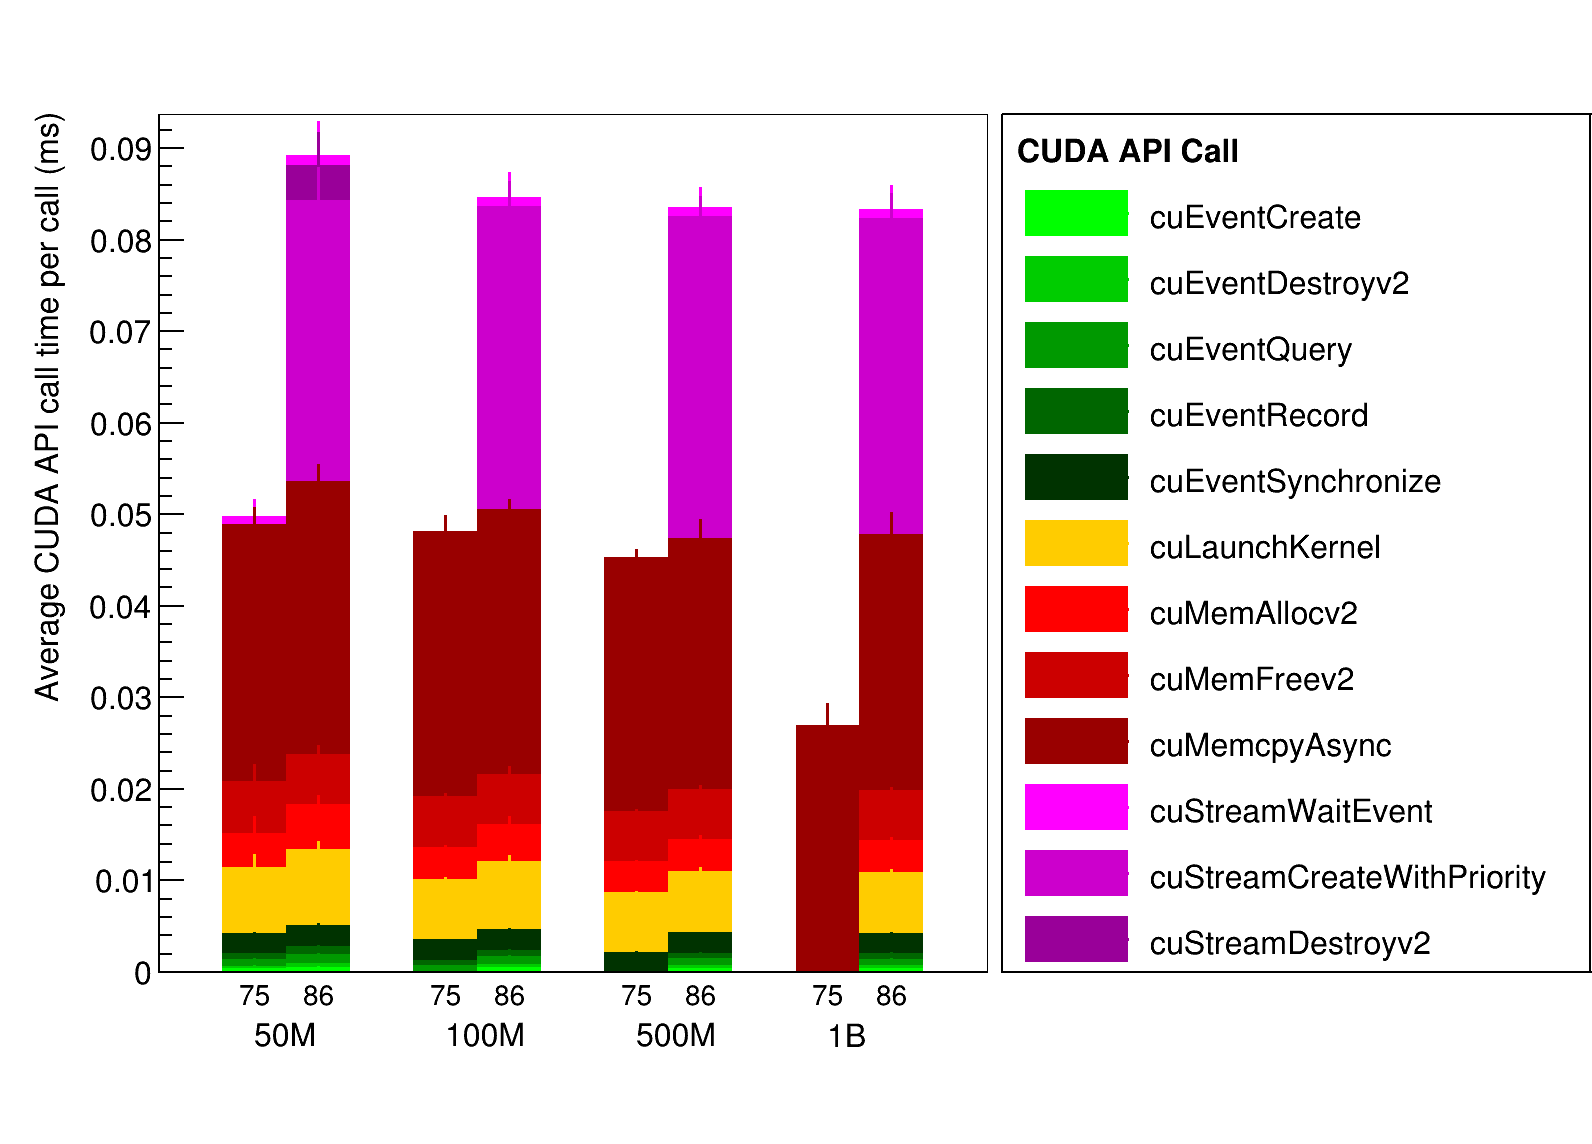

In [554]:
%jsroot off
selected_env = "DPC++"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [75,86]
selected_red = 8

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 2 * len(selected_nvals) + 5
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [40, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1200
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.15
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin, 1, 0.9)

# l = ROOT.TLegend()
l.SetTextSize(0.03)
l.SetHeader("#bf{CUDA API Call}")
    
unique_labels = []
for ci, cc in enumerate(selected_cc):    
    other = 0
    for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals): 
            if len(unique_labels) >-1:
                arg = (selected_env, selected_gpu, cc,
                       selected_type, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, selected_red)
                api_avg = gp_api.mean().loc[arg]
                api_std = gp_api.std().loc[arg]
                if "Module" in name:
                    continue
                if len(api_avg) == 0 or name not in api_avg.index:
                    continue
                if get_cell(api_avg, name, "Time (%)") == 0:
                    continue
                val = get_cell(api_avg, name, "Time")/get_cell(api_avg, name, "Num Calls")*1e3 
                color = get_color(name, unique_labels)
                h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
                fill_bar(
                    h3,
                    bin,
                    val,
                    get_cell(api_std, name, "Time")/get_cell(api_avg, name, "Num Calls")*1e3 ,
                    color,
                    None,
                )
                h3.SetLineWidth(3)
                hs.Add(h3)
                bin += 3
                if name not in unique_labels:
                    # if val > 1: 
                    #     l.AddEntry(h3, name)
                    # else:
                        # l.AddEntry(h3, "Other")
                    l.AddEntry(h3, name)
                    unique_labels.append(name)


hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-20
xtitle = ROOT.TLatex(0, xtoffset, "Target compute capability");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-5, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, typ in enumerate(selected_cc):
        xaxis.SetBinLabel(e + ei, f"{typ}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.03)
ox.SetLabelFont(42)
ox.SetLabelSize(0.03)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Average CUDA API call time per call (ms)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/dpcpp_aot_vs_jit_percall.pdf")
c.DrawClone()

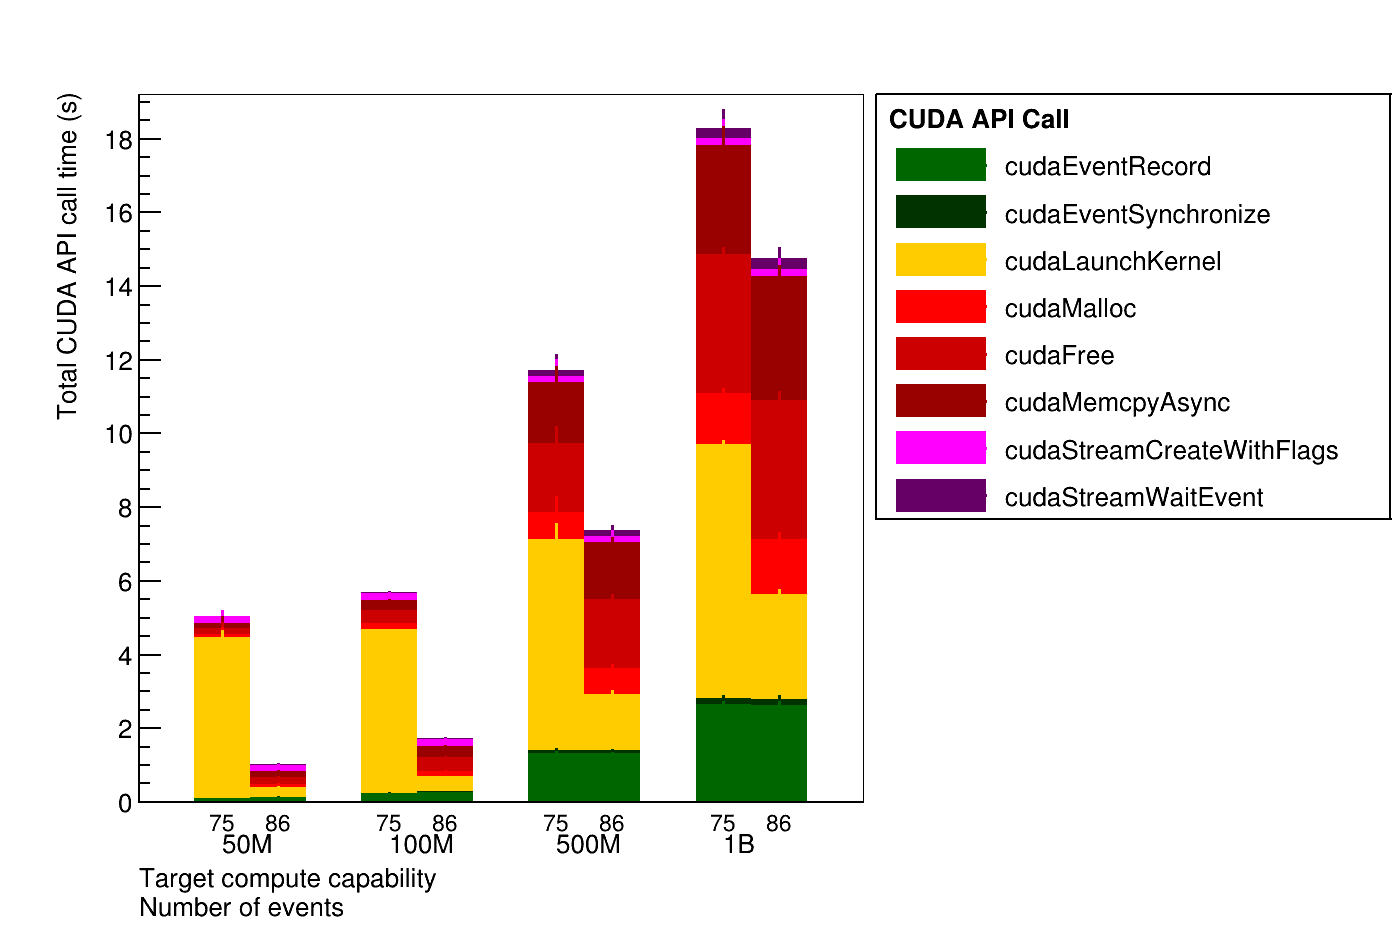

In [553]:
%jsroot off
selected_env = "AdaptiveCpp"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [75,86]
selected_red = 2
        
# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = 2 * len(selected_nvals) + 5
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [None, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1400
h = 1000
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.38
bmargin = 0.15
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin+0.3, 1, 0.9)
l.SetTextSize(0.03)
l.SetHeader("#bf{CUDA API Call}")

unique_labels = []
for ci, cc in enumerate(selected_cc):    
    ROOT.gStyle.SetPalette(ROOT.kRainbow)
    other = 0
    for ni, name in enumerate([
        'cudaEventRecord',
        'cudaEventSynchronize',
        'cudaLaunchKernel',
        'cudaMalloc',
        'cudaFree',
        'cudaMemcpyAsync',
        'cudaStreamCreateWithFlags',
        'cudaStreamWaitEvent',
    ]):
    # for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals):  
            arg = (selected_env, selected_gpu, cc,
                   selected_type, selected_distr, nv, selected_bins, 
                   selected_bulksize, selected_edges, selected_red)
            api_avg = gp_api.mean().loc[arg]
            api_std = gp_api.std().loc[arg]
    
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            if get_cell(api_avg, name, "Time (%)") == 0:
                continue
                
            val = get_cell(api_avg, name, "Time") 
            color = get_color(name, unique_labels)
            # color = ROOT.TColor.GetPalette()[7 * ni] 
            # color = ROOT.TColor.GetPalette()[6 * ni] if val > 1 else ROOT.kBlue
            h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                val,
                get_cell(api_std, name, "Time"),
                color,
                None,
            )
            h3.SetLineWidth(3)
            hs.Add(h3)
            bin += 3
            if name not in unique_labels:
                # if val > 1: 
                #     l.AddEntry(h3, name)
                # else:
                    # l.AddEntry(h3, "Other")
                l.AddEntry(h3, name)
                unique_labels.append(name)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-2.3
xtitle = ROOT.TLatex(0, xtoffset, "Target compute capability");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e
for i, e in enumerate(range(2, nbins, 3)):
    for ei, typ in enumerate(selected_cc):
        xaxis.SetBinLabel(e + ei, f"{typ}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)


ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.03)
ox.SetLabelSize(0.03)
ox.SetLabelFont(42)

labelbins = range(2, nbins + 1, 3)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 6, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)
l.Draw()

c.SaveAs(f"../../images/acpp_aot_vs_jit.pdf")
c.DrawClone()

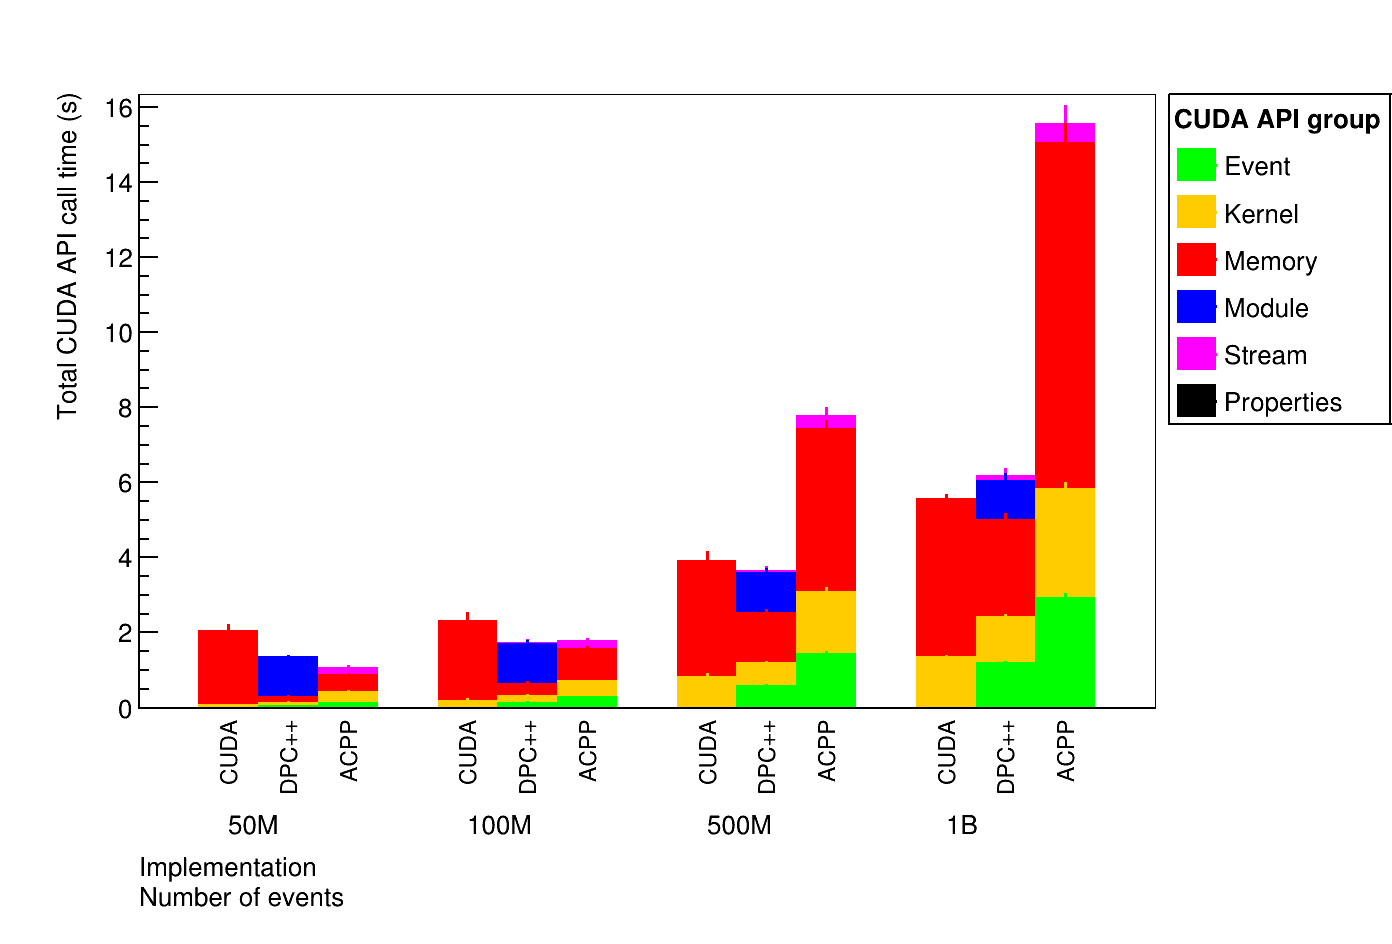

In [571]:
%jsroot off
selected_env = ["CUDA", "DPC++", "AdaptiveCpp"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = 86
selected_red = 2
        
# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_env) * len(selected_nvals) +  len(selected_nvals) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [None, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1400
h = 1000
c = ROOT.TCanvas("c1", title, w, h)

hs = ROOT.THStack("h1s", "")
rmargin = 0.17
bmargin = 0.25
c.SetRightMargin(rmargin)
c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,bmargin+0.3, 1, 0.9)
l.SetTextSize(0.03)
l.SetHeader("#bf{CUDA API group}")
                
unique_labels = []
for ei, env in enumerate(selected_env):    
    for nvi, nv in enumerate(selected_nvals):  
        g_vals = {
            "Event" : [0,0],
            "Kernel" : [0,0],
            "Memory" : [0,0],
            "Module" : [0,0],
            "Stream" : [0,0],
            "Properties" :[0,0],
        }
        
        bin = 1 + nvi * (len(selected_env) + 1) + ei
        for ni, name in enumerate(np.sort(api_names)):
            if "CUDA" in env: 
                arg = (env, selected_gpu, selected_cc,
                       selected_type, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, 8)
            else:
                arg = (env, selected_gpu, selected_cc,
                       selected_type, selected_distr, nv, selected_bins, 
                       selected_bulksize, selected_edges, selected_red)
            api_avg = gp_api.max().loc[arg]
            api_std = gp_api.std().loc[arg]
    
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            if get_cell(api_avg, name, "Time (%)") == 0:
                continue
                
            val_mean = get_cell(api_avg, name, "Time") 
            val_std = get_cell(api_std, name, "Time") 
            group = get_group(name)
            # print(env, nv, name, group, val_mean)
            g_vals[group][0] += val_mean
            g_vals[group][1] += val_std

        for g, v in g_vals.items():
            color = get_group_color(g)
            h3 = ROOT.TH1F(f"{env}_{nv}_{g}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                v[0],
                v[1],
                color,
                None,
            )
            h3.SetLineWidth(3)
            hs.Add(h3)
            if g not in unique_labels:
                l.AddEntry(h3, g)
                unique_labels.append(g)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xtoffset=-4.5
xtitle = ROOT.TLatex(0, xtoffset, "Implementation");
xtitle.Draw();
xtitle.SetTextSize(0.03)
xsubtitle = ROOT.TLatex(0, xtoffset-0.8, "Number of events");
xsubtitle.Draw();
xsubtitle.SetTextSize(0.03)

xaxis = hs.GetXaxis()
xaxis.SetTitle("")

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    elif e == "DPC++": 
        return "DPC++"
    return e
for i, e in enumerate(range(2, nbins, len(selected_env) + 1)):
    for ei, typ in enumerate(selected_env):
        xaxis.SetBinLabel(e + ei, f"{map_env(typ)}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("vM")
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.04)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "S hM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.11)
ox.SetLabelSize(0.03)
ox.SetLabelFont(42)

labelbins = range(2, nbins + 1, len(selected_env) + 1)
for i in range(nbins + 3):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 6, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.03)
yaxis.SetLabelSize(0.03)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)
l.Draw()

c.SaveAs(f"../../images/api_comparison_86.pdf")
c.DrawClone()

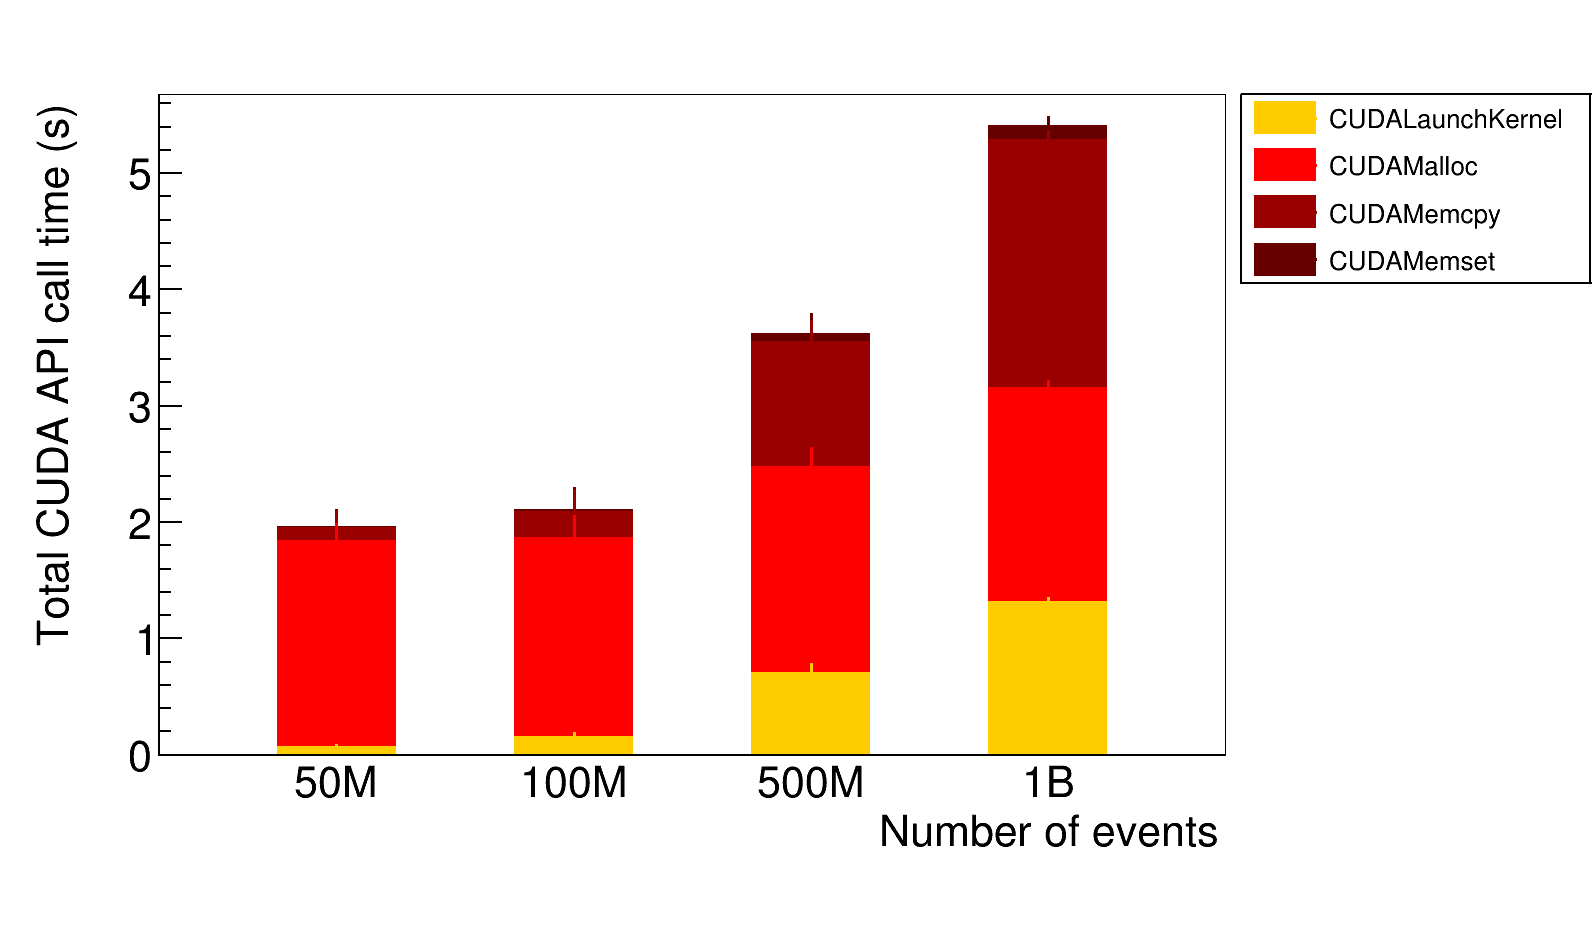

In [522]:
# %jsroot off
selected_env = "CUDA"
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [86]
selected_red = 8 # but its actually 2
        
# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_cc) * len(selected_nvals) + len(selected_nvals) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [None, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 1000
c = ROOT.TCanvas("c1", title, w, h)
c.SetBottomMargin(0.2)

hs = ROOT.THStack("h1s", "")
rmargin = 0.23
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.7, 1, 0.9)

# l = ROOT.TLegend()
l.SetTextSize(0.03)

unique_labels = []
for ci, cc in enumerate(selected_cc):    
    ROOT.gStyle.SetPalette(ROOT.kRainbow)
    other = 0
    for ni, name in enumerate(np.sort(api_names)):
        bin = 1 + ci 
        for nvi, nv in enumerate(selected_nvals):  
            arg = (selected_env, selected_gpu, cc,
                   selected_type, selected_distr, nv, selected_bins, 
                   selected_bulksize, selected_edges, selected_red)
            api_avg = gp_api.mean().loc[arg]
            api_std = gp_api.std().loc[arg]
    
            if len(api_avg) == 0 or name not in api_avg.index:
                continue
            if get_cell(api_avg, name, "Time (%)") == 0:
                continue
                
            val = get_cell(api_avg, name, "Time") 
            color = get_color(name, unique_labels)
            # color = ROOT.TColor.GetPalette()[7 * ni] 
            # color = ROOT.TColor.GetPalette()[6 * ni] if val > 1 else ROOT.kBlue
            h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                val,
                get_cell(api_std, name, "Time"),
                color,
                gpuFillStyle[ci],
            )
            h3.SetLineWidth(3)
            hs.Add(h3)
            bin += len(selected_cc) + 1
            if name not in unique_labels:
                # if val > 1: 
                #     l.AddEntry(h3, name)
                # else:
                    # l.AddEntry(h3, "Other")
                l.AddEntry(h3, name)
                unique_labels.append(name)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xaxis = hs.GetXaxis()
# xaxis.SetTitle("#splitline{          Compilation}{Number of kernels}")
xaxis.SetTitle("Number of events")
# xaxis.SetTitleOffset(3)
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.0)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "SM",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelFont(42)
ox.SetLabelSize(0.05)

labelbins = range(2, nbins + 1, 2)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e  in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, human_readable(selected_nvals[i]))

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total CUDA API call time (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)
l.Draw()
c.SaveAs(f"../../images/cuda_api.pdf")
c.DrawClone()

In [523]:
gp_api.mean().loc["CUDA"]

iter  \
gpu   cc type distribution nvals        nbins bulksize edges reduction Name                           
A4000 86 USM  uniform      5.000000e+07 1     32768    False 8         CUDAFree                 2.0   
                                                                       CUDALaunchKernel         2.0   
                                                                       CUDAMalloc               2.0   
                                                                       CUDAMemcpy               2.0   
                                                                       CUDAMemset               2.0   
...                                                                                             ...   
                           1.000000e+09 1000  32768    True  8         CUDALaunchKernel         2.0   
                                                                       CUDAMalloc               2.0   
                                                                       CUDAMemcpy               2.0   
                                                                       CUDAMemset               2.0   
                                                                       cuModuleGetLoadingMode   2.0   

                                                                                               Time (%)  \
gpu   cc type distribution nvals        nbins bulksize edges reduction Name                               
A4000 86 USM  uniform      5.000000e+07 1     32768    False 8         CUDAFree                    0.00   
                                                                       CUDALaunchKernel            3.66   
                                                                       CUDAMalloc                 90.80   
                                                                       CUDAMemcpy                  5.20   
                                                                       CUDAMemset                  0.32   
...                                                                                                 ...   
                           1.000000e+09 1000  32768    True  8         CUDALaunchKernel           24.40   
                                                                       CUDAMalloc                 33.96   
                                                                       CUDAMemcpy                 39.48   
                                                                       CUDAMemset                  2.16   
                                                                       cuModuleGetLoadingMode      0.00   

                                                                                               Total Time (ns)  \
gpu   cc type distribution nvals        nbins bulksize edges reduction Name                                      
A4000 86 USM  uniform      5.000000e+07 1     32768    False 8         CUDAFree                   3.203178e+05   
                                                                       CUDALaunchKernel           7.544392e+07   
                                                                       CUDAMalloc                 1.864574e+09   
                                                                       CUDAMemcpy                 1.066033e+08   
                                                                       CUDAMemset                 6.691951e+06   
...                                                                                                        ...   
                           1.000000e+09 1000  32768    True  8         CUDALaunchKernel           1.320916e+09   
                                                                       CUDAMalloc                 1.837792e+09   
                                                                       CUDAMemcpy                 2.135384e+09   
                                                                       CUDAMemset                 1.163212e+0

# Reduction

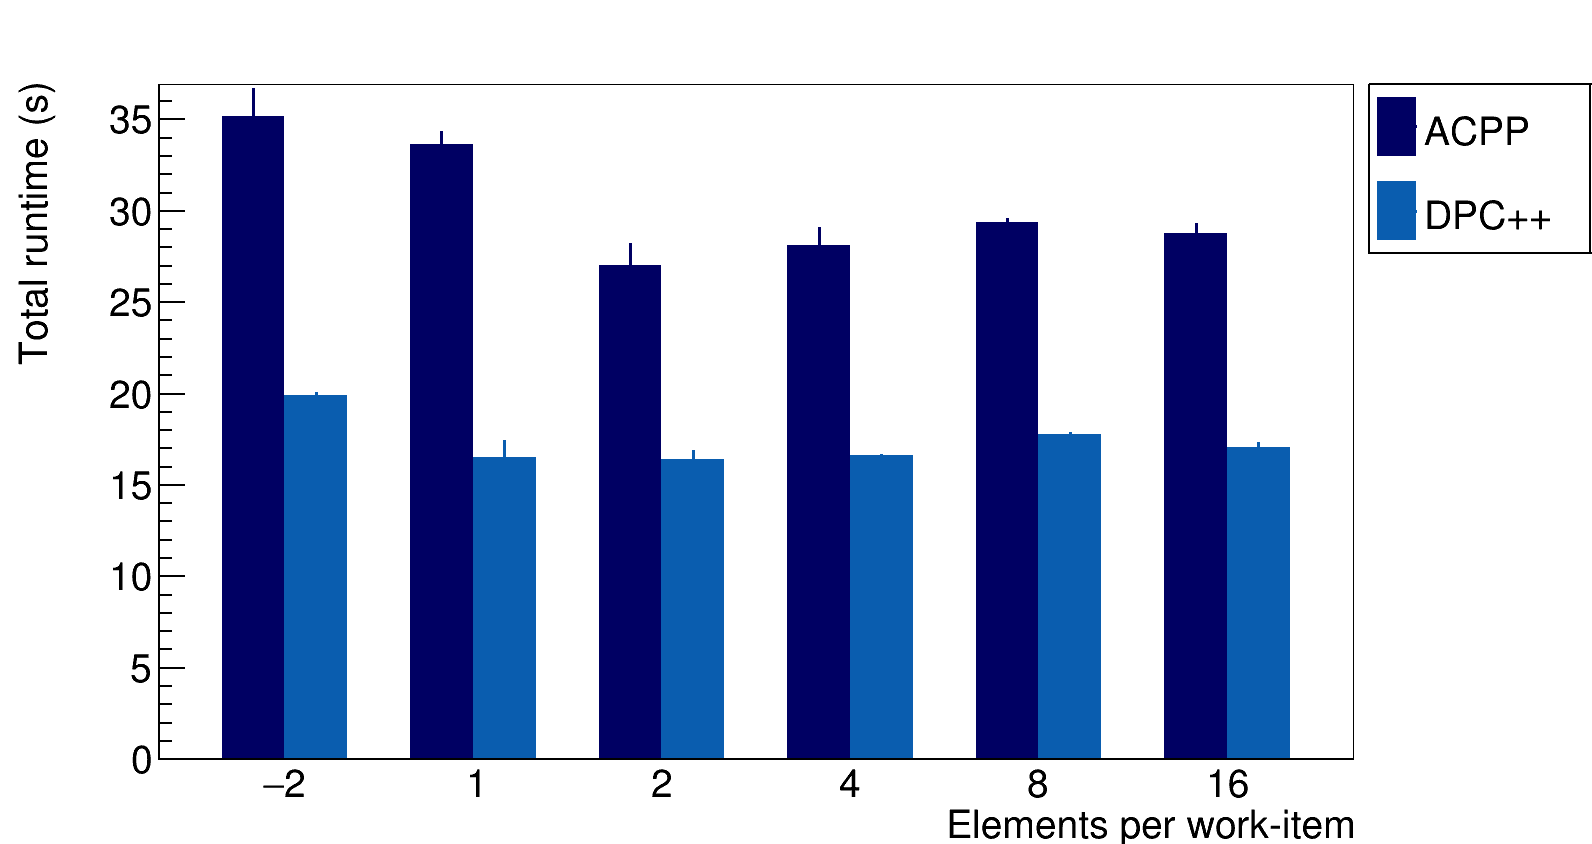

In [524]:
%jsroot off
selected_env = ["AdaptiveCpp", "DPC++"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = [1000e6]
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [86]
selected_red = unique_reduction

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_env) * len(selected_red) + len(selected_red) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [None, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)
# c.SetBottomMargin(0)

hs = ROOT.THStack("h1s", "")
rmargin = 0.15
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.7, 1, 0.9)
l.SetTextSize(0.05)

unique_labels = []

for ei, env in enumerate(selected_env):    
    bin = 1 + ei 
    for ri, rng in enumerate(selected_red):    
        arg = (env, selected_gpu, selected_cc,
               selected_type, selected_distr, selected_nvals, selected_bins, 
               selected_bulksize, selected_edges, rng)
        avg = gp.mean().loc[arg]
        std = gp.std().loc[arg]

        color = ROOT.TColor.GetPalette()[50 * ei] 
        h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
        fill_bar(
            h3,
            bin,
            avg["ttotal"].iloc[0],
            std["ttotal"].iloc[0],
            color,
            gpuFillStyle[ci],
        )
        h3.SetLineWidth(3)
        hs.Add(h3)
        bin += 3
        if env not in unique_labels:
            l.AddEntry(h3, map_env(env))
            unique_labels.append(env)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xaxis = hs.GetXaxis()
xaxis.SetTitle("Elements per work-item")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "Sm",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelFont(42)
ox.SetLabelSize(0.05)

labelbins = range(3, nbins, 3)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, f"{selected_red[i]}")
ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total runtime (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/reduction_range.pdf")
c.DrawClone()

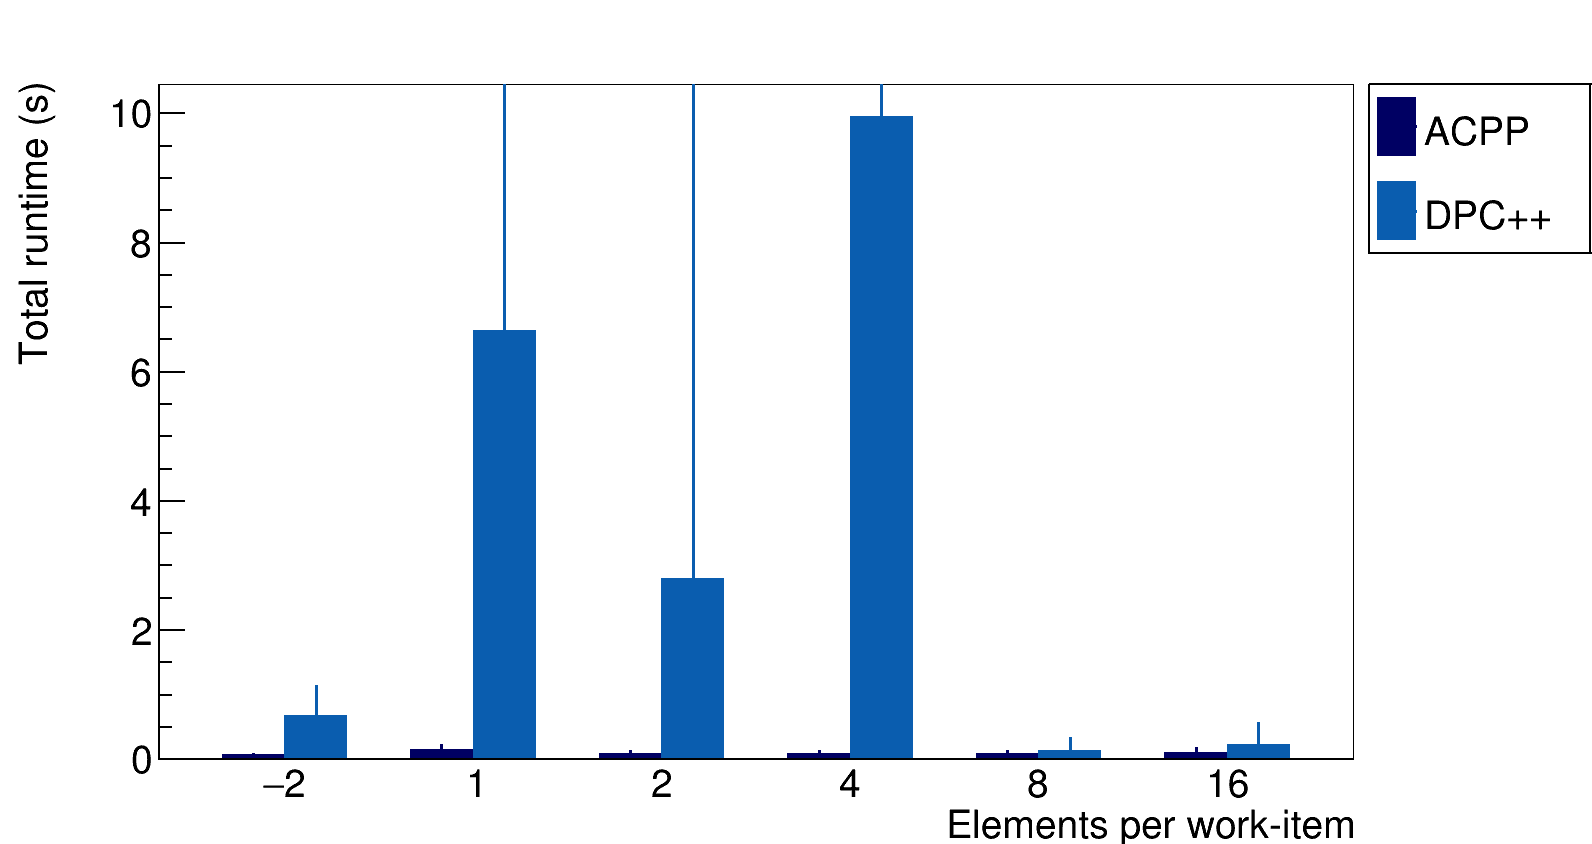

In [525]:
%jsroot off
selected_env = ["AdaptiveCpp", "DPC++"]
selected_bulksize = 32768
selected_type = "USM"
selected_bins = 1000
selected_nvals = [1000e6]
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True
selected_cc = [86]
selected_red = unique_reduction

# nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
nbins = len(selected_env) * len(selected_red) + len(selected_red) + 1
title = f""
# title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [None, None, None, None, None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)
# c.SetBottomMargin(0)

hs = ROOT.THStack("h1s", "")
rmargin = 0.15
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.7, 1, 0.9)
l.SetTextSize(0.05)

unique_labels = []

for ei, env in enumerate(selected_env):    
    bin = 1 + ei 
    for ri, rng in enumerate(selected_red):
        # for ni, name in enumerate(kernel_names):
        #     if not "reduce" in name or not "sum" in name:
        #         continue
        name = 'Statistics reductions'
        arg = (env, selected_gpu, selected_cc,
               selected_type, selected_distr, selected_nvals, selected_bins, 
               selected_bulksize, selected_edges, rng, name)
        avg = gp_kernels.mean().loc[arg]
        std = gp_kernels.std().loc[arg]

        color = ROOT.TColor.GetPalette()[50 * ei] 
        h3 = ROOT.TH1F(f"{cc}_{nv}_{name}", "gpu", nbins, 0, nbins)
        fill_bar(
            h3,
            bin,
            avg["Time"].iloc[0] ,
            std["Time"].iloc[0],
            color,
            gpuFillStyle[ci],
        )
        h3.SetLineWidth(3)
        hs.Add(h3)
        bin += 3
        if env not in unique_labels:
            l.AddEntry(h3, map_env(env))
            unique_labels.append(env)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xaxis = hs.GetXaxis()
xaxis.SetTitle("Elements per work-item")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
    "Sm",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelFont(42)
ox.SetLabelSize(0.05)

labelbins = range(3, nbins, 3)
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 0, -1, -1, f"{selected_red[i]}")
ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Total runtime (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# c.SetLogy()

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.SaveAs(f"../../images/reduction_range_kernel.pdf")
c.DrawClone()

In [526]:
avg

,,,,,,,,,,,iter,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Time
env,gpu,cc,type,distribution,nvals,nbins,bulksize,edges,reduction,Name,,,,,,,,,,
DPC++,A4000,86,USM,uniform,1.000000e+09,1000,32768,True,16,Statistics reductions,2.0,10.6875,226288642.0,19083.25,12326.0225,12360.4375,9409.175,14700.95,2863.8,0.226289


## A6000

## A2